In [1]:
import numpy as np
import functools as FT
from math import log 
import copy
import pandas as pd
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

## Data

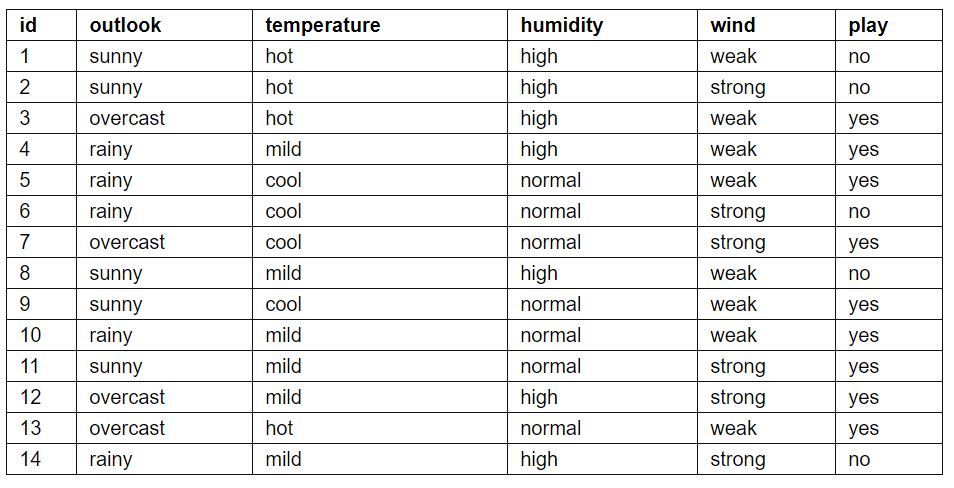

In [2]:
data = [{'id' : 1, 'outlook': 'sunny', 'temperature': 'hot', 'humidity': 'high', 'wind': 'weak', 'play' : 'no'},
        {'id' : 2, 'outlook': 'sunny', 'temperature': 'hot', 'humidity': 'high', 'wind': 'strong', 'play' : 'no'},
        {'id' : 3, 'outlook': 'overcast', 'temperature': 'hot', 'humidity': 'high', 'wind': 'weak', 'play' : 'yes'},
        {'id' : 4, 'outlook': 'rainy', 'temperature': 'mild', 'humidity': 'high', 'wind': 'weak', 'play' : 'yes'},
        {'id' : 5, 'outlook': 'rainy', 'temperature': 'cool', 'humidity': 'normal', 'wind': 'weak', 'play' : 'yes'},
        {'id' : 6, 'outlook': 'rainy', 'temperature': 'cool', 'humidity': 'normal', 'wind': 'strong', 'play' : 'no'},
        {'id' : 7, 'outlook': 'sunny', 'temperature': 'cool', 'humidity': 'normal', 'wind': 'strong', 'play' : 'yes'},
        {'id' : 8, 'outlook': 'sunny', 'temperature': 'mild', 'humidity': 'high', 'wind': 'weak', 'play' : 'no'},
        {'id' : 9, 'outlook': 'sunny', 'temperature': 'cool', 'humidity': 'normal', 'wind': 'weak', 'play' : 'yes'},
        {'id' : 10, 'outlook': 'rainy', 'temperature': 'mild', 'humidity': 'normal', 'wind': 'weak', 'play' : 'yes'},
        {'id' : 11, 'outlook': 'sunny', 'temperature': 'mild', 'humidity': 'normal', 'wind': 'strong', 'play' : 'yes'},
        {'id' : 12, 'outlook': 'overcast', 'temperature': 'mild', 'humidity': 'high', 'wind': 'strong', 'play' : 'yes'},
        {'id' : 13, 'outlook': 'overcast', 'temperature': 'hot', 'humidity': 'normal', 'wind': 'weak', 'play' : 'yes'},
        {'id' : 14, 'outlook': 'rainy', 'temperature': 'mild', 'humidity': 'high', 'wind': 'strong', 'play' : 'no'}]

In [3]:
'''def count_play(data):
    return FT.reduce(lambda c,x: c + 1 if x['play'] == 'yes' else c , data, 0) == len(data)'''
def convert_data(lst):
    domain = list(set(lst))
    return list(map(lambda value: domain.index(value), lst))
def entropy(y):
    set_y = set(y)
    num_classes = len(set_y)
    prob_each_class = np.zeros((num_classes))
    for i, yi in enumerate(set_y):
        prob_each_class[i] = len(y[y == yi]) / len(y)
        if prob_each_class[i] == 1:
            return 0
    result = 0
    for i in range(num_classes):
        result += -prob_each_class[i] * log(prob_each_class[i])
    
    return result
def find_mode(arr):
    domain = set(arr)
    mode = -1
    max_count = 0
    for label in domain:
        count = 0
        for num in arr:
            if label == num:
                count += 1
                
        if count > max_count:
            mode = label
            max_count = count
            
    return mode

##Utils Functions

##Recursive ID3 function

In [4]:
class DecisionTree:
    def __init__(self, max_depth = 999999):
        '''
        - children 
        - feature
        '''
        self.children = {}
        self.features = []
        self.out = -1
        self.min_atribute = ''
        self.max_depth = max_depth
    def fit(self, X, y, features):
        self.features = features
        self.entropy = entropy(y)
        if self.entropy == 0:
            self.out = y[0]
            return 
        
        if self.max_depth == 0:
            self.out = find_mode(y)
            return
        
        num_atribute = len(X[0])
        min_entropy = 999999999
        min_atribute = ''
        for i in features:
            if i in features:
                value_domain = set(X[:,i])
                sum_entropy = 0
                for value in value_domain:
                    mask_idx = X[:,i] == value
                    #sub_X = X[mask_idx]
                    sub_y = y[mask_idx]
                    p_sub = len(sub_y) / len(y)
                    sum_entropy += p_sub * entropy(sub_y)
                
                if sum_entropy < min_entropy:
                    min_entropy = sum_entropy
                    min_atribute = i
        
        if min_atribute == '':
            self.out = find_mode(y)
        else:
            self.min_atribute = min_atribute
            value_domain = set(X[:, min_atribute])
            features.remove(min_atribute)
            for value in value_domain:
                mask_idx = X[:,min_atribute] == value
                sub_X = X[mask_idx]
                sub_y = y[mask_idx]
                sub_tree = DecisionTree(max_depth = self.max_depth - 1)
                self.children[value] = sub_tree
                sub_tree.fit(sub_X, sub_y, features)

            features.append(min_atribute)
                
    def predict_once(self, input):
        "Predict classes for a list of input"
        if self.children:
            
            min_atribute = self.min_atribute
            for key, sub_tree in self.children.items():
                if key == input[min_atribute]:
                    return sub_tree.predict_once(input)
            
            return sub_tree.predict_once(input)
            
        return self.out
    
    def predict(self, inputs):
        result = []
        
        for input in inputs:
            out = self.predict_once(input)
            result.append(out)
            
        return result
        

In [5]:
class RandomForest:
    def __init__(self, num_tree = 10, max_depth = 999999):
        self.lst_tree = []
        self.max_depth = max_depth
        self.num_tree = num_tree
        for i in range(num_tree):
            self.lst_tree.append(DecisionTree(max_depth = max_depth))
        
    def fit(self, X, y, features, ratio = 0.5):
        n = len(y)
        for tree in self.lst_tree:
            temp = np.arange(n)
            mask = np.random.choice(temp,size = int(ratio * n))
            
            X_train = X[mask]
            y_train = y[mask]
            tree.fit(X_train, y_train, features)
        
    
    def predict_once(self, input):
        result = []
        for tree in self.lst_tree:
            result.append(tree.predict_once(input))
        
        return find_mode(result)
            
    def predict(self,inputs):
        result = []
        
        for input in inputs:
            out = self.predict_once(input)
            result.append(out)
            
        return result

In [6]:
# #y = convert_data([row['play'] for row in data])
# df = pd.DataFrame(data)
# y = np.array(list(df['play']))
# X = np.array(df.drop(columns=['id', 'play']).values.tolist())
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Classifier = DecisionTree()
# Classifier.fit(X_train, y_train,[0,1,2,3])
# for i, x in enumerate(X_test):
#     print(Classifier.predict(x), y_test[i])

##Main

In [7]:
f = open("lenses.data", "r")
raw = f.read().split('\n')
data = np.array([row.split() for row in raw][:-1])
X, y = data[:,1:5],data[:,5]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
Classifier = DecisionTree()
Classifier.fit(X_train, y_train, [0,1,2,3])


y_predict = Classifier.predict(X_test)    
print(classification_report(y_test,y_predict))


num_feature = 5
lst_feature = [i for i in range(num_feature - 1)]
Classifier = RandomForest(num_tree = 10, max_depth = 5)
Classifier.fit(X_train, y_train, lst_feature,  ratio = 0.8)


y_predict = Classifier.predict(X_test)
print(classification_report(y_test,y_predict))


              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           3       0.80      1.00      0.89         4

    accuracy                           0.80         5
   macro avg       0.40      0.50      0.44         5
weighted avg       0.64      0.80      0.71         5

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           3       0.80      1.00      0.89         4

    accuracy                           0.80         5
   macro avg       0.40      0.50      0.44         5
weighted avg       0.64      0.80      0.71         5



C:\Users\viett\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[24]
 [45]
 [43]
 ...
 [39]
 [33]
 [17]]


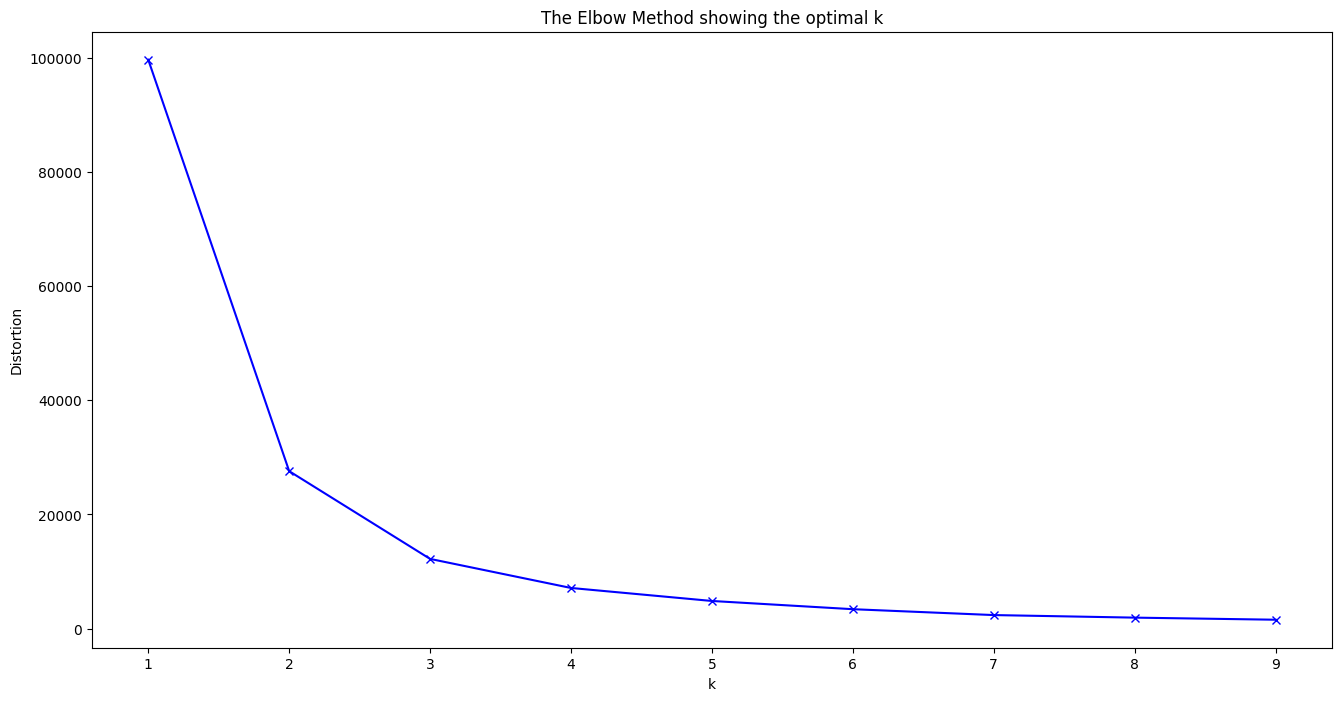

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [40]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

f = open("cmc.data", "r")
raw = f.read().split('\n')
data = np.array([row.split(',') for row in raw][:-1], dtype = np.int64)
X = data[:,:1]
print(X)
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

kmeanModel = KMeans(n_clusters=2)
kmeanModel.fit(X)


In [59]:
f = open("cmc.data", "r")
raw = f.read().split('\n')
data = np.array([row.split(',') for row in raw][:-1], dtype = np.int64)
num_feature = len(data[0])-1
X, y = data[:,:num_feature],data[:,num_feature]
X[:,0] = kmeanModel.predict(X[:,:1]).flatten()


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train[0])

lst_feature = [i for i in range(num_feature)]
Classifier = DecisionTree()
Classifier.fit(X_train, y_train, lst_feature)


y_predict = Classifier.predict(X_test)
print(classification_report(y_test,y_predict))


lst_feature = [i for i in range(num_feature)]
Classifier = RandomForest(num_tree = 10, max_depth = 8)
Classifier.fit(X_train, y_train, lst_feature, ratio = 1)


y_predict = Classifier.predict(X_test)
print(classification_report(y_test,y_predict))

[ 1  2  4 11  1  1  1  4  1]
              precision    recall  f1-score   support

           1       0.57      0.60      0.58       130
           2       0.41      0.34      0.37        71
           3       0.41      0.44      0.42        94

    accuracy                           0.48       295
   macro avg       0.46      0.46      0.46       295
weighted avg       0.48      0.48      0.48       295

              precision    recall  f1-score   support

           1       0.60      0.69      0.64       130
           2       0.46      0.41      0.43        71
           3       0.46      0.39      0.42        94

    accuracy                           0.53       295
   macro avg       0.50      0.50      0.50       295
weighted avg       0.52      0.53      0.52       295



In [50]:
f = open("car.data", "r")
raw = f.read().split('\n')
data = np.array([row.split(',') for row in raw][:-1])
num_feature = len(data[0]) - 1
X, y = data[:,:num_feature],data[:,num_feature]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, X_test.shape)
lst_feature = [i for i in range(num_feature)]
Classifier = DecisionTree()
Classifier.fit(X_train, y_train, lst_feature)


y_predict = Classifier.predict(X_test)
y_predict = np.array(y_predict)
print(y_predict[:10])
print(y_test[:10])
print(y_test.shape, y_predict.shape) 
print(classification_report(y_test,y_predict))


lst_feature = [i for i in range(num_feature)]
Classifier = RandomForest(num_tree = 10)
Classifier.fit(X_train, y_train, lst_feature,  ratio = 0.8)

y_predict = Classifier.predict(X_test)
print(classification_report(y_test,y_predict))
    




(1209, 6) (519, 6)
['unacc' 'good' 'unacc' 'acc' 'unacc' 'acc' 'unacc' 'unacc' 'acc' 'unacc']
['unacc' 'acc' 'unacc' 'acc' 'unacc' 'acc' 'unacc' 'unacc' 'unacc' 'unacc']
(519,) (519,)
              precision    recall  f1-score   support

         acc       0.90      0.81      0.85       118
        good       0.60      0.79      0.68        19
       unacc       0.98      0.97      0.97       358
       vgood       0.66      0.88      0.75        24

    accuracy                           0.92       519
   macro avg       0.78      0.86      0.81       519
weighted avg       0.93      0.92      0.93       519

              precision    recall  f1-score   support

         acc       0.88      0.77      0.82       118
        good       0.50      0.74      0.60        19
       unacc       0.97      0.97      0.97       358
       vgood       0.66      0.88      0.75        24

    accuracy                           0.91       519
   macro avg       0.75      0.84      0.78       519
w

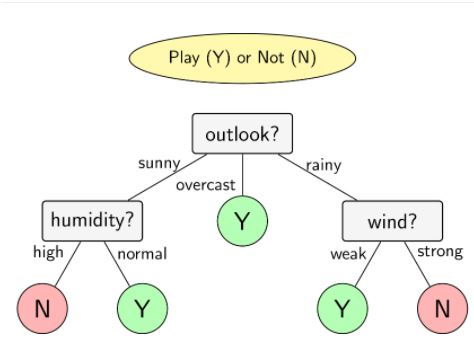